V tem "notebooku" bom implementiral binarni klasifikator, ki bo na podlagi naslovov dnevnih novic, napovedal gibanje borznega indeksa. 
Na začetku naložim in uvozim potrebne knjižnice.

In [2]:
library(ggplot2)
library(rvest)
library(gsubfn)
library(readr)
library(dplyr)

Obravnaval bom gibanje ameriškega borznega indeksa Dow Jones. Podatke sem zajel z naslednje strani:
https://www.google.com/finance/historical?cid=983582&startdate=Aug%208%2C%202008&enddate=Jul%201%2C%202016&num=30&ei=I-YFWcG9KsnCswHvtaTACg&start=0

## Obdelava, uvoz in čiščenje podatkov

Pri delu sem si pomagal s knjižnico RVEST in regularnimi izrazi. Ker so se podatki nahajali na različnih straneh, sem s for zanko poskrbel, da sem zajel podatke z vsake izmed njih (spreminjal sem samo parameter 'start' v url naslovih). Zbrana tabela obsega podatke o dnevnem gibanju za 8 let (2008-2016). Tabeli sem dodal še stolpec "Gibanje", ki pove, ali se je tisti dan indeks premaknil nazvgor (1) ali navzdol (0). Na koncu zbrane in urejene podatke shranim v datoteko "DowJones.csv".

In [9]:
link <- "https://www.google.com/finance/historical?cid=983582&startdate=Aug%208%2C%202008&enddate=Jul%201%2C%202016&num=30&ei=I-YFWcG9KsnCswHvtaTACg&start=0"
stran <- html_session(link) %>% read_html()
tabela <- stran %>% html_nodes(xpath="//table[@class='gf-table historical_price']") %>%
     .[[1]] %>% html_table(dec = ",")

In [10]:
for (x in 1:66) {
    link <- "https://www.google.com/finance/historical?cid=983582&startdate=Aug%208%2C%202008&enddate=Jul%201%2C%202016&num=30&ei=I-YFWcG9KsnCswHvtaTACg&start=0"
    link <- gsub('^(.+start=)(\\d+)$', '\\1', link)
    x <- x * 30
    x <- as.character(x)
    link <- paste(link, x, sep="")
    stran <- html_session(link) %>% read_html()
    pomozna <- stran %>% html_nodes(xpath="//table[@class='gf-table historical_price']") %>%
     .[[1]] %>% html_table(dec = ",")
    tabela <- rbind(tabela, pomozna)
}

In [11]:
en <- locale("en", date_format = "%b %d, %Y", decimal_mark = ".", grouping_mark = ",")
tabela <- tabela %>% transmute(Date = parse_date(Date, locale = en),
                               Open = parse_number(Open, locale = en),
                               Close = parse_number(Close, locale = en)) %>%
                              mutate(Gibanje = ifelse(Open < Close, 1, 0))


In [12]:
head(tabela)

Date,Open,Close,Gibanje
2016-07-01,17924.24,17949.37,1
2016-06-30,17712.76,17929.99,1
2016-06-29,17456.02,17694.68,1
2016-06-28,17190.51,17409.72,1
2016-06-27,17355.21,17140.24,0
2016-06-24,17946.63,17400.75,0


In [20]:
write.csv(tabela, file = "files/DowJones.csv")

Naslove najpopularnejših novic sem uvozil kar v obliki csv. Tako obliko podatkov sem našel na naslednjem naslovu: https://www.kaggle.com/aaron7sun/stocknews
Tabela vključuje dva stoplca, "Date" in "News". Pri vsakem datumu je nato vnešenih 25 naslovov dnevnih novic.
Obdelava podatkov je obsegala naslednje korake:
- iz naslovov sem odstranil znak "$" (izkazalo se je namreč, da kasneje lahko povzroča težave) in b', ki se pojavlja na začetku nekaterih naslovov
- združil sem novice za posamezni datum. Tako imam samo po en vnos za en datum, ne 25 različnih vnosov kot prej. To sem dosegel s pomočjo funkcije "group_by".
- odstranil sem vse "non alphanumeric" znake, razen presledkov in apostrofov

In [3]:
D2 <- read_csv("files/RedditNews.csv", col_types = cols(Date = col_date()))
head(D2)
dim(D2)

Date,News
2016-07-01,"A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898."
2016-07-01,IMF chief backs Athens as permanent Olympic host
2016-07-01,"The president of France says if Brexit won, so can Donald Trump"
2016-07-01,British Man Who Must Give Police 24 Hours' Notice of Sex Threatens Hunger Strike: The man is the subject of a sexual risk order despite having never been convicted of a crime.
2016-07-01,100+ Nobel laureates urge Greenpeace to stop opposing GMOs
2016-07-01,Brazil: Huge spike in number of police killings in Rio ahead of Olympics


[1] 73608     2

In [5]:
D2$News <- gsub('b"|b\'|\\\\|\\"', "", D2$News)

In [17]:
write.csv(D2, file = "files/ocisceni_naslovi.csv")

In [6]:
news <- D2 %>% group_by(Date) %>% summarise(News = paste(News, collapse = " "))
head(news)

Date,News
2008-06-08,"Nim Chimpsky: The tragedy of the chimp who thought he was a boy (and proved that humans were not humane)' Canada: Beware slippery slope' to censorship, hearing told EU Vice-President Luisa Morgantini and the Irish Nobel laureate, Mairead Corrigan, have been tear gased and injured by the IDF while attending the International Conference on Non-violent Resistance' Israeli minister: Israel will attack Iran if it doesn't abandon its nuclear program Albino Killings in Tanzania. At least 19 albinos, including several young children, have been killed in Tanzania in the past year. [video] ' Chiapas: army occupies Zapatista communities in anti-drug ops' Polar bear swims 200 miles, is shot dead upon arrival' News is a contraband item in Pakistan now, and it is being sold on the black market,' Albinos, Long Shunned, Face Threat in Tanzania where witch doctors are now marketing albino skin, bones and hair as ingredients in potions that are promised to make people rich.' Town in Britain Plans to Start its Own Currency' BBC reporter among 16 dead in Afghanistan' Lebanese women still vulnerable to violence: existing legal framework violates international human rights law because it fails to protect women from domestic violence' Police release chilling images of man left for dead by hit-and-run driver' Iceland opens Europe's largest national park. The 15.000 square kilometer (5792 square mile) Vatnajkull National Park. Citizens fighting Blackwater Potrero. Was the location chosen so they can train cheap Mexican soldiers or so they can perform extraordinary rendition from a partner facility in Mexico' S. Korean protesters, police clash in beef rallies--don't want US beef... Oil reserves 'will last decades' - a BBC Scotland investigation has been told Cameras designed to detect terrorist facial expressions' Israeli peace activists protest 41 years of occupation' A 5.1 earthquake hits China's Southern Qinghai province. Man goes berzerk in Akihabara and stabs everyone nearby: 6 dead, 12 injured ' Threat of world AIDS pandemic among heterosexuals is over, report admits' Angst in Ankara: Turkey Steers into a Dangerous Identity Crisis' UK: Identity cards 'could be used to spy on people' and a new children's database may be used to identify likely future criminals. Has covert surveillance gone too far? Marriage, they said, was reduced to the status of a commercial transaction in which women could be discarded by husbands claiming to have discovered hidden defects in them.'"
2008-06-09,"United States quits Human Rights Council' Pentagon blocked Cheney's attack on Iran 'J Street,' a new liberal Jewish organization, hopes to challenge AIPAC's influence over U.S.-Israeli affairs Former Ambassador Joseph Wilson: [The U.S. Military is] proselytizing not on behalf of the Constitution of the United States . . . but rather on behalf of some sort of fanatical view of end times' EU leaders anxiously await Irish verdict on Lisbon Treaty. Ireland, the only country allowed a referendum will vote on June 12th. ' 17 Hit or Stabbed, 7 Confirmed Dead in Tokyo's Akihabara Treaty tensions mount as Iraq tells the US it wants all troops back in barracks' Council paints over street artist Banksy's graffiti murals - worth a fortune! Finders keepers can get complicated when half a billion dollars and lawyers are involved' Chew Qat: In Yemen, 72 per cent of men and 32 per cent of women chew qat for two to six hours a day' One of UKs most experienced and decorated special forces soldiers has quit the army after criticising the government for risking soldiers lives by failing to fund troops and equipment.' A bitter struggle between two powerful Beltway terrorism analysts has broken out as to whether Al Qaeda is still alive and well.' Jailers at Guantanamo urged to destroy interrogation notes: lawyer' 80% UK Laws Now Made In Brussels and the UK Parliament has no power to reject or amend them. Few voters realize how many powers have been, or are about to be, 

In [7]:
#news$News <- gsub('b"|b\'|\\\\|\\"', "", news$News) 
news$News <- gsub("[^[:alnum:][:space:]']", "", news$News)
news$News <- gsub("^c(.+)$", "\\1", news$News)
news$News <- gsub('^(.*)(\\$)(.*)$', '\\1\\3', news$News)

Sedaj obe tabeli staknem z "inner join-om" po stolpcu "Date". Rezultat je končna tabela s petimi stoplci: "Date", "Open", "Close", "Gibanje" in "News". Podatki so tako pripravljeni za nadaljnjo analizo (uporaba metod strojnega učenja in poskus napovedanja gibanja indeksa na podlagi naslovov). Tabelo še shranim v "Zdruzena.csv".

In [13]:
test <- inner_join(tabela, news, by = "Date")

In [14]:
head(test)

Date,Open,Close,Gibanje,News
2016-07-01,17924.24,17949.37,1,A 117yearold woman in Mexico City finally received her birth certificate and died a few hours later Trinidad Alvarez Lira had waited years for proof that she had been born in 1898 IMF chief backs Athens as permanent Olympic host The president of France says if Brexit won so can Donald Trump British Man Who Must Give Police 24 Hours' Notice of Sex Threatens Hunger Strike The man is the subject of a sexual risk order despite having never been convicted of a crime 100 Nobel laureates urge Greenpeace to stop opposing GMOs Brazil Huge spike in number of police killings in Rio ahead of Olympics Austria's highest court annuls presidential election narrowly lost by rightwing candidate Facebook wins privacy case can track any Belgian it wants Doesn't matter if Internet users are logged into Facebook or not Switzerland denies Muslim girls citizenship after they refuse to swim with boys at school The 12 and 14yearold will no longer be considered for naturalised citizenship because they have not complied with the school curriculum authorities in Basel said China kills millions of innocent meditators for their organs report finds France Cracks Down on Factory Farms A viral video campaign has moved the govt to act In footage shared widely online animals writhe in pain as they bleed to death or are dismembered in violation of rules requiring they be rendered unconscious before slaughter Abbas PLO Faction Calls Killer of 13YearOld AmericanIsraeli Girl a Martyr Taiwanese warship accidentally fires missile towards China Iran celebrates American Human Rights Week mocks US rights record UN panel moves to curb bias against LGBT people despite fierce resistance from Muslim and African countries The United States has placed Myanmar Uzbekistan Sudan and Haiti on its list of worst human trafficking offenders SampP revises European Union credit rating to 'AA' from 'AA' India gets 1 billion loan from World Bank for solar mission US sailors detained by Iran spoke too much under interrogation Navy Mass fish kill in Vietnam solved as Taiwan steelmaker accepts responsibility for pollution Philippines president Rodrigo Duterte urges people to kill drug addicts Duterte 71 won power in a landslide after a campaign dominated by threats to kill tens of thousands in a war on crime Spain arrests three Pakistanis accused of promoting militancy Venezuela where anger over food shortages is still mounting continued to be roiled this week by angry protests and breakins of grocery stores and businesses that have left five dead at least 30 injured and 200 arrested according to various news reports A Hindu temple worker has been killed by three men on a motorcycle local police have said More than 40 people have been killed in attacks blamed on Islamist militants in Bangladesh since February 2013 including secular bloggers academics gay rights activists and members of religious minorities Ozone layer hole seems to be healing US amp UK team shows it's shrunk amp may slowly recover If you had to have an ozone hole anywhere in the world it'd be Antarctica because its not teeming with life It showed us if we didnt back off with these chemicals wed have a crisis
2016-06-30,17712.76,17929.99,1,Jamaica proposes marijuana dispensers for tourists at airports following legalisation The kiosks and desks would give people a license to purchase up to 2 ounces of the drug to use during their stay Stephen Hawking says pollution and 'stupidity' still biggest threats to mankind we have certainly not become less greedy or less stupid in our treatment of the environment over the past decade Boris Johnson says he will not run for Tory party leadership Six gay men in Ivory Coast were abused and forced to flee their homes after they were pictured signing a condolence book for victims of the recent attack on a gay nightclub in Florida Switzerland denies citizenship to Muslim immigrant girls who refused to swim with boys report Palestini

In [15]:
dim(test)
dim(tabela)

[1] 1990    5

[1] 1990    4

In [16]:
write.csv(test, file = "files/Zdruzena.csv")

## Analiza in vizualizacija podatkov

Podatke zbrane v prvi tabeli lahko tudi grafično predstavim. Spodaj je prikazan graf gibanja indeksa v letih 2008-2016. Vidimo, da je z izjemo prvih let po krizi (2008, 2009) indeks v povprečju vseskozi rastel. Ker bo za nadaljno analizo pomembno v kakšnem razmerju so vzponi in padci (oz. enke in ničle v stoplcu "Gibanje"), preštejem še to. Ugotovim, da so podatki lepo porazdeljeni po obeh razredih, tj. v 54% opazovanih dni je indeks rastel (kar na prvi pogled sicer ni očitno iz grafa).

In [4]:
tabela <- read_csv("files/DowJones.csv")
zdruzena <- read_csv("files/Zdruzena.csv")

`geom_smooth()` using method = 'gam'


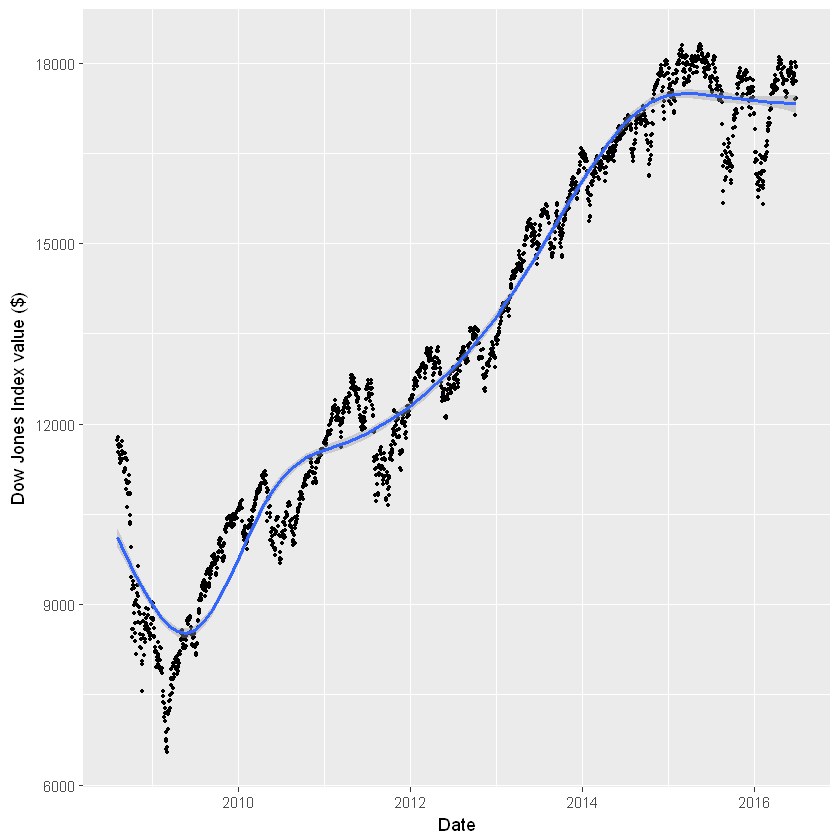

In [20]:
ggplot(data = tabela, mapping = aes(x = Date, y = Close)) + 
     geom_point(size=0.75) + geom_smooth() + labs(x = "Date", y = "Dow Jones Index value ($)")

In [21]:
gor <- sum(tabela$Gibanje)
gor
round(gor/dim(tabela)[1], 2) 

[1] 1075

[1] 0.54

V sklopu analize, lahko tudi pogledam, katere besede so se najpogosteje pojavljale v naslovih novic v zadnjih osmih letih. To storim tako, da združim vse naslove in nato preštejem, kolikokrat se je pojavila posamezna beseda. To tabelo shranim v "besede.csv"

In [5]:
novice <- zdruzena$News
m <- ""
for (i in 1:1990) {
    m <- paste(m, novice[[i]])
}

besede <- table(strsplit(m, split = " ", fixed = TRUE))
besede <- data.frame(besede)
besede <- besede[with(besede, order(-Freq)), ]
besede$Var1 <- as.character(besede$Var1)
#tabela <- tabela[nchar(tabela$Var1) > 5]
colnames(besede)<- c("Beseda","Stevilo_pojavitev")
head(besede)

,Beseda,Stevilo_pojavitev
55102,the,27049
55688,to,25646
39731,of,22703
30222,in,21862
6277,a,14205
8242,and,12284


In [57]:
pogoste <- besede[besede$'Stevilo_pojavitev' > 250,]

In [6]:
write.csv(besede, file = "files/besede.csv")
write.csv(pogoste, file = "files/pogoste.csv")

Uporabljenih je bilo kar 61252 različnih besed.

In [23]:
dim(besede)

[1] 61252     2

TO DO: opis word clouda

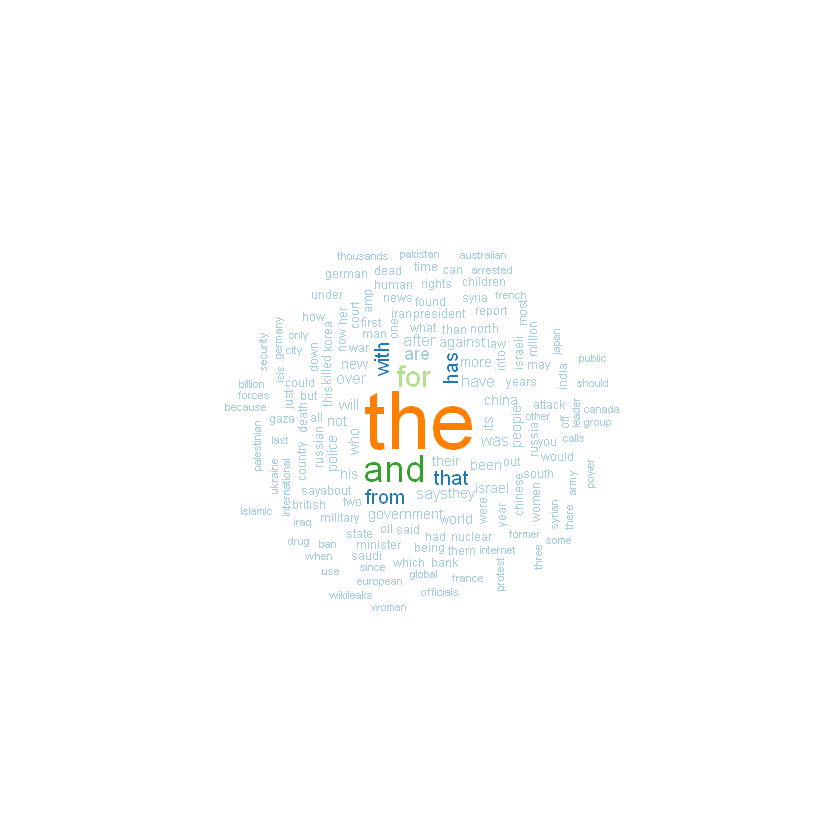

In [55]:
#install.packages('tm', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('RColorBrewer', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('wordcloud', dependencies = TRUE, repos = "http://cran.us.r-project.org")

library(tm)
library(RColorBrewer)
library(wordcloud)

besede.corpus <- Corpus(DataframeSource(data.frame(zdruzena$News)))

wordcloud(besede.corpus,
          max.words = 150,
          random.order=FALSE, 
          rot.per=0.30, 
          use.r.layout=FALSE, 
          colors=brewer.pal(8, "Paired"))

Če me zanima, kolikokrat se je pojavila "Slovenija", lahko to enostavno preverim.

In [32]:
besede[besede$Beseda == 'Slovenia',]
besede[besede$Beseda == 'Slovenian',]

,Beseda,Število pojavitev
51236,Slovenia,10


,Beseda,Število pojavitev
51238,Slovenian,3


Podobno lahko storim za naše sosede in dobim naslednjo tabelo. Rezultate prikažem še na zemljevidu.

In [25]:
slo <- besede[besede$Beseda == 'Slovenia',]
cro <- besede[besede$Beseda == 'Croatia',]
aus <- besede[besede$Beseda == 'Austria',]
hun <- besede[besede$Beseda == 'Hungary',]
ita <- besede[besede$Beseda == 'Italy',]
rez <- rbind(slo, cro, aus, hun, ita)

rez

,Beseda,Število pojavitev
51236,Slovenia,10
17713,Croatia,16
9942,Austria,40
29558,Hungary,74
31748,Italy,192


Warning message:
"Removed 251 rows containing missing values (geom_text)."

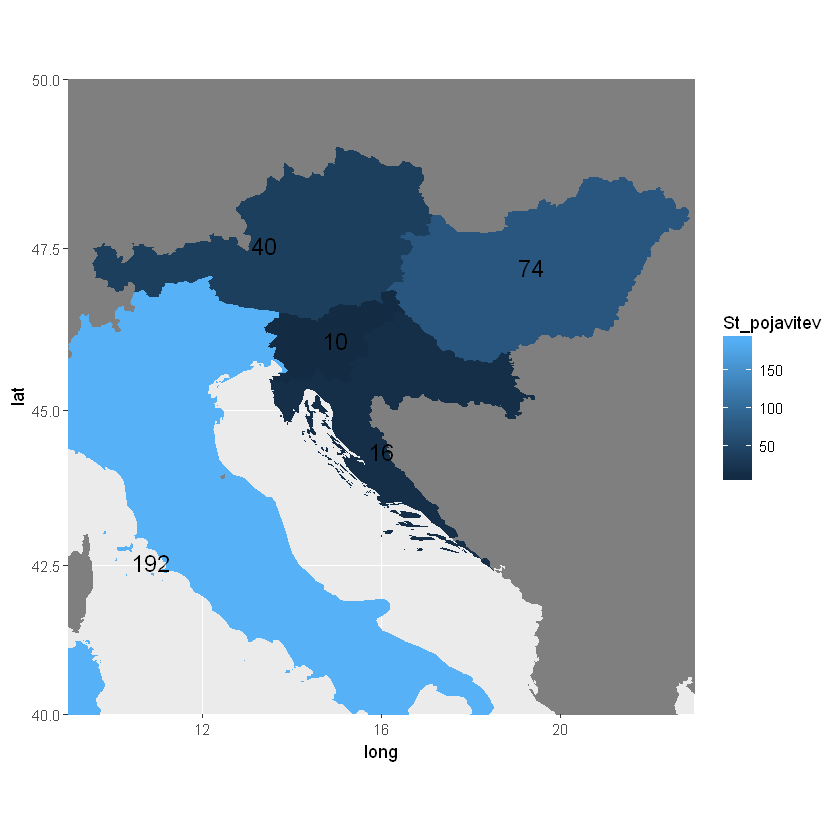

In [31]:
library(sp)
library(maptools)
source("https://raw.githubusercontent.com/jaanos/APPR-2017/master/lib/uvozi.zemljevid.r")

rez$CNTR <- c("SI", "HR", "AT", "HU", "IT")
rez$CNTR <- as.factor(rez$CNTR)
colnames(rez) <- c("Beseda", "St_pojavitev", "CNTR")

evropa <- uvozi.zemljevid("http://ec.europa.eu/eurostat/cache/GISCO/geodatafiles/CNTR_2014_03M_SH.zip",
                       "CNTR_2014_03M_SH/Data/CNTR_RG_03M_2014", encoding = "Windows-1250") %>% pretvori.zemljevid()

tmp <- left_join(evropa, rez, by = c("CNTR_ID" = "CNTR"))

tmp2 <- tmp %>% group_by(CNTR_ID, St_pojavitev) %>% summarise(x = mean(long), y = mean(lat))

ggplot() +
  geom_polygon(data = tmp, aes(x = long, y = lat, group = group, fill = St_pojavitev)) +
  geom_text(data = tmp2, aes(x = x, y = y, label = St_pojavitev), size = 5) +
  coord_map(xlim = c(9, 23), ylim = c(40, 50))

Preverim še pogostost pojavitev pomembnih političnih oseb (tu sem upošteval le novice v letih 2015 in 2016). Vidim, da je bil Trump 2x bolj pogosto omenjen v novicah kot Hillary Clinton (pri tem je treba upoštevati, da podatki zajemajo le novice do julija 2016, se pravi glavnina volilnega dogajanja v ZDA ni zajeta). Zanimivo je še, da je bil ruski predsednik Putin pogosteje omenjen kot Obama. 

In [37]:
#vzamem samo novice v letih 2015 in 2016
zdruzena <- zdruzena[1:380,]
aktualno <- zdruzena$News
m <- ""
for (i in 1:380) {
    m <- paste(m, aktualno[[i]])
}

tabela2 <- table(strsplit(m, split = " ", fixed = TRUE))
tabela2 <- data.frame(tabela2)
tabela2 <- tabela2[with(tabela2, order(-Freq)), ]
tabela2$Var1 <- as.character(tabela2$Var1)
a <- tabela2[tabela2$Var1 == 'Trump',]
b <- tabela2[tabela2$Var1 == "Trump's",]
c <- tabela2[tabela2$Var1 == 'Clinton',]
d <- tabela2[tabela2$Var1 == "Clinton's",]
e <- tabela2[tabela2$Var1 == 'Sanders',]
#tabela2[tabela2$Var1 == 'Donald',]
#tabela2[tabela2$Var1 == 'Hillary',]
f <- tabela2[tabela2$Var1 == 'Obama',]
g <- tabela2[tabela2$Var1 == 'Putin',]
h <- tabela2[tabela2$Var1 == 'Erdogan',]
j <- tabela2[tabela2$Var1 == 'Cameron',]
i <- tabela2[tabela2$Var1 == 'Snowden',]

osebe <- rbind(a, b, c ,d, e, f, g, h, j, i)
colnames(osebe) <- c("Oseba", "Število omemb")
osebe

,Oseba,Število omemb
21476,Trump,21
21477,Trump's,4
5377,Clinton,9
5379,Clinton's,1
18349,Sanders,1
14797,Obama,128
16857,Putin,136
8208,Erdogan,50
4619,Cameron,48
19437,Snowden,63


TO DO:
- popraviti datum (da ni treba klikati nazaj od maja 2017)
- popraviti kaj se zgodi, če vnešeš besedo, ki je ni v bazi
- opis aplikacije v notebooku

Shiny web aplikacija (arhiv dnevnih novic) je dostopna na naslednjem spletnem naslovu: https://metodjazbec.shinyapps.io/test1/

In [ ]:
library(shiny)
library(shinythemes)
#deployApp()
ui <- fluidPage(
  theme = shinytheme("united"),
  tabsetPanel(
    tabPanel(title = "Title search",
             wellPanel(
               fluidRow(
                 headerPanel("Daily news' titles archive (2008-2016)"),
                 column(3, dateInput(inputId = "datum",
                                     label = "Date [YYYY-MM-DD]",
                                     min = as.Date(0, origin = "2008-06-08"),
                                     max = as.Date(2945, origin = "2008-06-08")
                 ),
                 numericInput(inputId = "stevilo",
                              label = "Number of news [1-25]",
                              value = 1,
                              min = 1,
                              max = 20
                 ),
                 actionButton("display", "Display")),
                 column(5, tags$img(height = 100, width = 200, 
                                    src = "reddit.png"), offset = 4))),
             tableOutput("tabelaNovic")),
    tabPanel(title = "Word frequency",
             wellPanel(
               fluidRow(
                 headerPanel("Word frequency"),
                 column(3, 
                        textInput(inputId = "beseda",
                                  label = "Insert word"
                        ),
                        actionButton("display2", "Display")),
                 column(5, tags$img(height = 150, width = 200, 
                                    src = "wordcloud.png"), offset = 4))),
             tableOutput("pogostostBesede")), type = "pills"
  )
)


server <- function(input, output) {
  
  novice <- eventReactive(input$display, {
    novice <- read.csv("RedditNews.csv")
    novice$Date <- as.Date(novice$Date)
    novice$News <- as.character(novice$News)
    novice <- novice[novice[,1] == as.character(input$datum),]
    novice <- novice[1:input$stevilo,]
    novice$nr <- c(1:input$stevilo)
    novice <- novice[,c("nr", "News")]
  })
  
  word <- eventReactive(input$display2, {
    word <- read.csv("besede.csv")
    word <- word[word$Beseda == input$beseda,]
    word <- word[,2:3]
  })
  
  output$tabelaNovic <- renderTable({
    novice()
  })
  
  output$pogostostBesede <- renderTable({
    word()
  }, bordered = TRUE)
  
}


shinyApp(ui = ui, server = server)


Listening on http://127.0.0.1:5737


## Napredna analiza podatkov

TO DO: binarni klasifikator

In [7]:
#library(tm)
#library(RWeka)
#library(magrittr)
#library(Matrix)
#library(glmnet)
#library(ROCR)

data <- read_csv("files/Zdruzena.csv")
data$X1 <- NULL
data$Open <- NULL
data$Close <- NULL

control <- list(
  removeNumbers = TRUE,
  tolower = TRUE,
  stopwords = c(stopwords(kind = 'SMART'))
)


dtm <- Corpus(VectorSource(data$News)) %>% 
  DocumentTermMatrix(control=control)

split_index <- data$Date <= "2014-12-31"


ytrain <- as.factor(data$Gibanje[split_index])
xtrain <- Matrix(as.matrix(dtm)[split_index, ], sparse=TRUE)

ytest <- as.factor(data$Gibanje[!split_index])
xtest <- Matrix(as.matrix(dtm)[!split_index, ], sparse=TRUE)

glmnet.fit <- cv.glmnet(x=xtrain, y=ytrain, family='binomial', alpha=0)
preds <- predict(glmnet.fit, newx=xtest, type='response', s='lambda.min')
results <- data.frame(pred=preds, actual=ytest)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  Date = col_date(format = ""),
  Open = col_double(),
  Close = col_double(),
  Gibanje = col_integer(),
  News = col_character()
)


In [9]:
prediction <- prediction(preds, ytest)
perf <- performance(prediction, measure = "tpr", x.measure = "fpr")

auc <- performance(prediction, measure = "auc")
auc <- auc@y.values[[1]]
auc

[1] 0.5

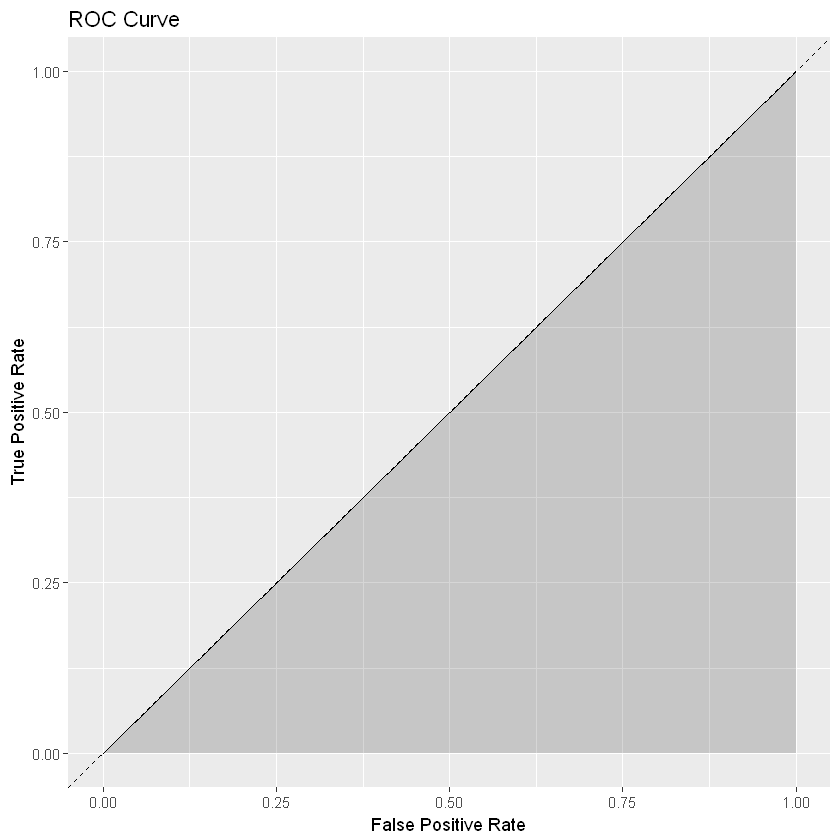

In [10]:
roc.data <- data.frame(fpr=unlist(perf@x.values),
                       tpr=unlist(perf@y.values))

ggplot(roc.data, aes(x=fpr, ymin=0, ymax=tpr)) +
    geom_ribbon(alpha=0.2) +
    geom_line(aes(y=tpr)) +
    geom_abline(slope=1, intercept=0, linetype='dashed') +
    ggtitle("ROC Curve") +
    ylab('True Positive Rate') +
    xlab('False Positive Rate')